# Ten Years Stroke project

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from pgmpy.estimators import HillClimbSearch, BicScore, PC, AICScore
from pgmpy.models import BayesianNetwork

In [99]:
dataframe = pd.read_csv('tenyear_stroke.csv')
dataframe.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [100]:
continuous_data = dataframe[['age','totChol','sysBP','diaBP','BMI','glucose']]
discrete_data = dataframe[['male','currentSmoker','prevalentStroke','prevalentHyp','diabetes','TenYearCHD']]

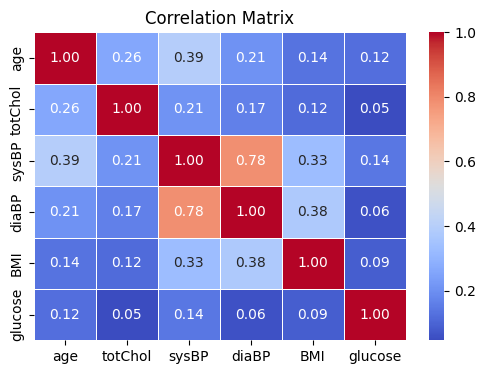

In [101]:
# Step 1: Calculate the correlation matrix
corr_matrix = continuous_data.corr()

# Step 2: Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Step 3: Show the plot
plt.title("Correlation Matrix")
plt.show()


In [102]:
from pgmpy.estimators.CITests import chi_square

print(chi_square(X='currentSmoker',Y='BMI', Z=[] ,data=dataframe, significance_level = 0.05))

False


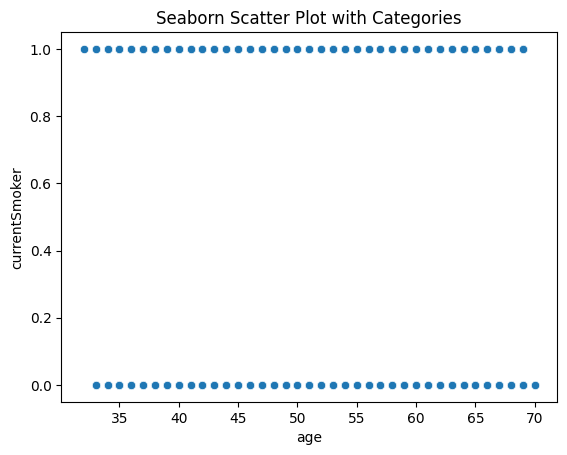

In [113]:
import seaborn as sns

# Scatter plot with hue
sns.scatterplot(data=dataframe, x='age', y='currentSmoker')

plt.title('Seaborn Scatter Plot with Categories')
plt.show()


# Detect outliers and filter the space



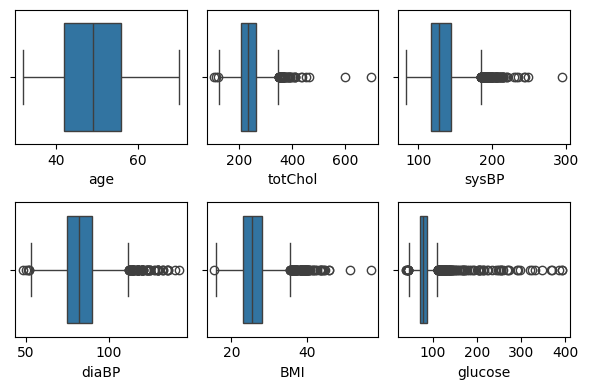

In [104]:
# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(6, 4))  # Adjust size for better spacing

# Flatten the 2D array of axes to make indexing easier
axes = axes.flatten()
features = continuous_data.columns
# Plot a box plot for each feature
for i, feature in enumerate(features):
    sns.boxplot(x=continuous_data[feature], ax=axes[i])
    axes[i].set_xlabel(feature)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [107]:
continuous_data_cl = continuous_data.dropna()

In [108]:
continuous_data_cl.loc[:,'age'] = continuous_data_cl['age'].where((continuous_data_cl['age'] >= 40) & (continuous_data_cl['age'] <= 65))
continuous_data_cl.loc[:,'age'] = pd.cut(continuous_data_cl.age,bins=[40,49,59,65],labels=[0,1,2],ordered=False).astype(float)



/var/folders/cx/0m_1by150cjf9gr9hmb90p3c0000gn/T/ipykernel_80032/3770091818.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan 46. 48. ... 51. 48. 52.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  continuous_data_cl.loc[:,'age'] = continuous_data_cl['age'].where((continuous_data_cl['age'] >= 40) & (continuous_data_cl['age'] <= 65))


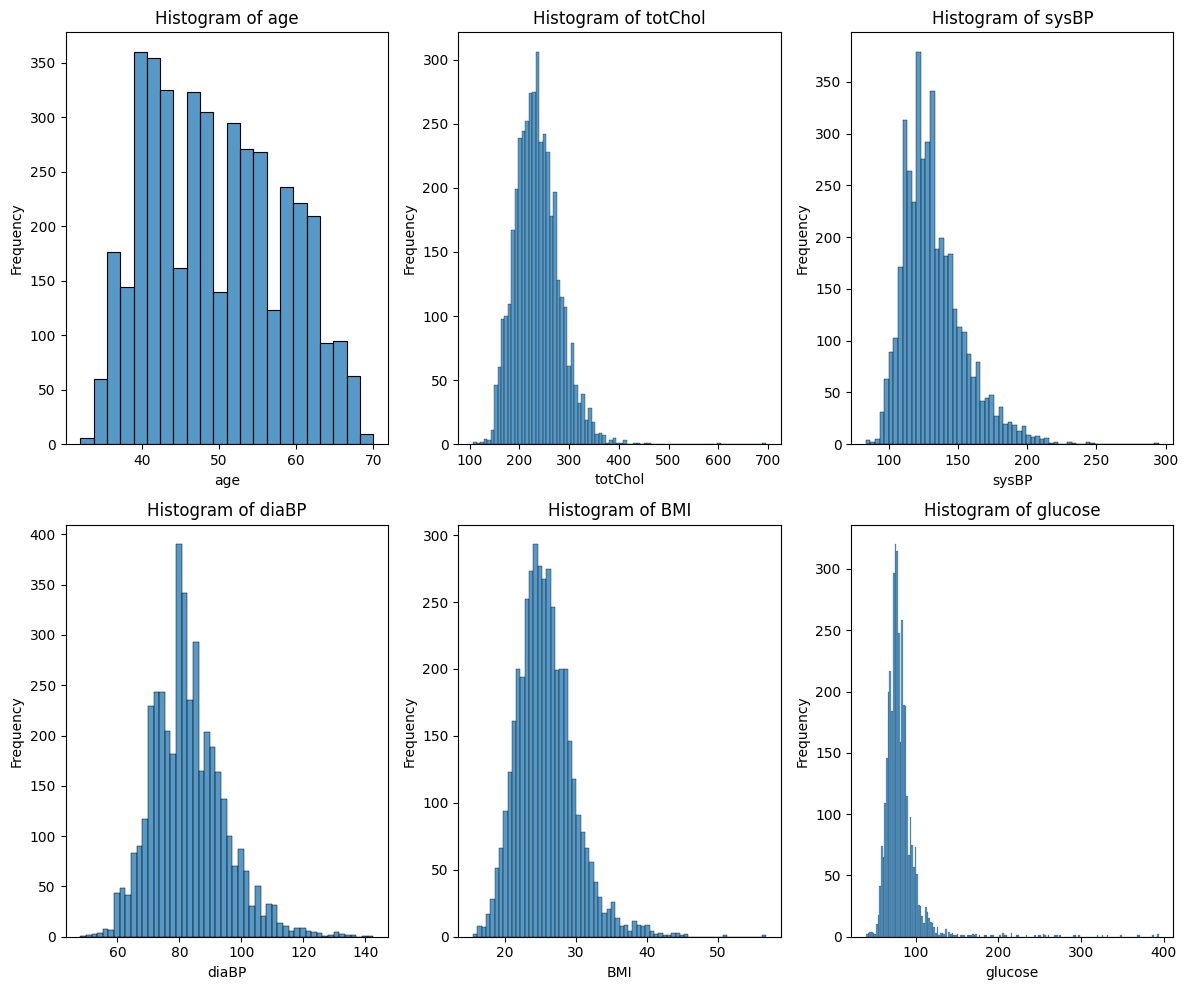

In [109]:
# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(12, 10))  # Adjust size for better spacing

# Flatten the 2D array of axes to make indexing easier
axes = axes.flatten()

# Plot a histogram for each feature
for i, feature in enumerate(features):
    sns.histplot(continuous_data[feature], kde=False, ax=axes[i])  # Change bins for granularity
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [110]:
import pandas as pd
discr_labels_5 = ['0','1','2','3','4']
discr_labels_4 = ['0','1','2','3']
#continuous_data_cl.loc[:,'cigsPerDay'] = pd.cut(continuous_data_cl.cigsPerDay,bins=[-1,0,10,20,30],labels=discr_labels_4,ordered=False).astype(float)
continuous_data_cl.loc[:,'totChol'] = pd.cut(continuous_data_cl.totChol,bins=[0,159,199,239,279,500],labels=discr_labels_5,ordered=False).astype(float)
continuous_data_cl.loc[:,'sysBP'] = pd.cut(continuous_data_cl.sysBP,bins=[0,119,129,139,159,500],labels=discr_labels_5,ordered=False).astype(float)
continuous_data_cl.loc[:,'diaBP'] = pd.cut(continuous_data_cl.diaBP,bins=[0,79,89,119,float('inf')],labels = discr_labels_4,ordered=False).astype(float)
continuous_data_cl.loc[:,'BMI'] = pd.cut(continuous_data_cl.BMI,bins=[0,18.5,24.9,29.9,34.9,float('inf')],labels=discr_labels_5,ordered=False).astype(float)
#continuous_data_cl.loc[:,'heartRate'] = pd.cut(continuous_data_cl.heartRate,bins=[0,59,99,float('inf')],labels = [0,1,2],ordered=False).astype(float)
continuous_data_cl.loc[:,'glucose'] = pd.cut(continuous_data_cl.glucose,bins=[0,69,99,125,float('inf')],labels=discr_labels_4,ordered=False).astype(float)

continuous_data_cl = continuous_data_cl.astype('str')

In [111]:
continuous_data_cl.columns=['A','C','SBP','DBP','BMI','G']
discrete_data.columns = ['S','SM','PS','PH','D','TYS']

dataset = pd.concat([continuous_data_cl,discrete_data],axis=1)

encoder = LabelEncoder()

for col in dataset.columns :
    dataset[col] = encoder.fit_transform(dataset[col])
dataset.head()

,A,C,SBP,DBP,BMI,G,S,SM,PS,PH,D,TYS
0,3,1,0,0,2,1,1,0,0,0,0,0
1,0,3,1,1,2,1,0,0,0,0,0,0
2,0,3,1,1,2,1,1,1,0,0,0,0
3,2,2,3,2,2,2,0,1,0,1,0,1
4,0,4,2,1,1,1,0,1,0,0,0,0


In [112]:
from pgmpy.estimators.CITests import chi_square

print(chi_square(X='A',Y='SM', Z=[] ,data=dataset, significance_level = 0.05))

False


In [72]:
fixed_edges = [('A','BMI'),('G','BMI'),('S','BMI'),
               ('A','C'),('A','G'),('BMI','G'),('BMI','C')]
forbidden_edges= [(var,"A") for var in dataset.columns if var != "A"] + \
                  [(var,"G") for var in dataset.columns if var != "G"] + \
                      [(var,"SM") for var in dataset.columns if var != "G"]
                      
hill = HillClimbSearch(dataset)
best_model = hill.estimate(scoring_method=AICScore(dataset),black_list=forbidden_edges)
nodes = best_model.nodes()
edges = best_model.edges()

print(edges)
                      

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('A', 'SBP'), ('A', 'C'), ('A', 'TYS'), ('SBP', 'DBP'), ('SBP', 'PH'), ('DBP', 'BMI'), ('DBP', 'PH'), ('BMI', 'S'), ('G', 'D'), ('G', 'SM'), ('S', 'C'), ('S', 'D'), ('SM', 'S'), ('SM', 'BMI'), ('SM', 'TYS'), ('SM', 'D'), ('PH', 'TYS'), ('PH', 'PS'), ('TYS', 'S'), ('TYS', 'PS')]


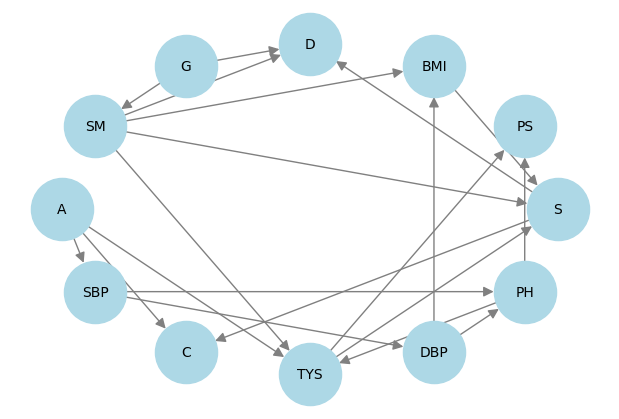

In [73]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a pgmpy model
model = BayesianNetwork(edges)

# Convert to a networkx graph
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Draw the graph
plt.figure(figsize=(6, 4))
pos = nx.shell_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, arrowsize=15)

plt.show()